# Mulitvariable Synthesis Simulation
- make toy data with continuous and categorical data


## Testing
- Categorical - Categorical 
- Categorical - Numerical 
- Numerical - Numerical

먼저 2개의 변수에 대해서 분석한다.

In [2]:
import numpy as np
import pandas as pd
import os, sys
from pathlib import Path

In [3]:
PROJECT_PATH = Path().cwd().parent
DATA_PATH = PROJECT_PATH.joinpath('data/processed')

In [4]:
toy_data = pd.DataFrame({
    "ID": [x for x in range(1,101)],
    "SEX":np.random.choice(range(0,2), 100, p=[0.6, 0.4], replace=True),
    "AGE":np.random.normal(51, 2, size=100),
    "HR" : np.random.random_integers(40,100, 100),
    "CANCER_SEVERITY":np.random.choice(range(0,3), 100, p=[0.7,0.2,0.1], replace=True),
    "MED_STATUS" : np.random.choice(['A','B','C','D'], 100, p = [0.1,0.3,0.2,0.4], replace=True)
})

toy_data.head()

,ID,SEX,AGE,HR,CANCER_SEVERITY,MED_STATUS
0,1,1,51.774304,95,0,D
1,2,1,53.284400,78,0,B
2,3,0,50.777864,74,1,B
3,4,1,47.253403,84,0,B
4,5,0,50.353262,87,0,C


Make toy data

<AxesSubplot:>

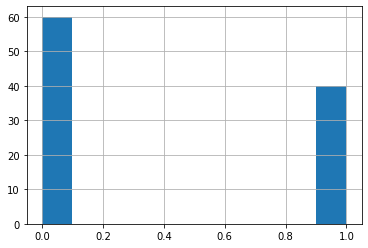

In [5]:
toy_data.SEX.hist()

<AxesSubplot:>

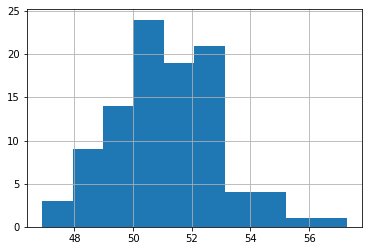

In [6]:
toy_data.AGE.hist()

<AxesSubplot:>

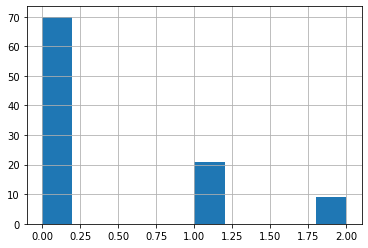

In [7]:
toy_data.CANCER_SEVERITY.hist()

<AxesSubplot:>

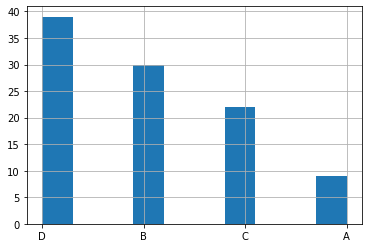

In [8]:
toy_data.MED_STATUS.hist()

TGAN - which is an article wrote for tabular data synthesis - writes that before they synthesized the dataset, scaling preprocessing was implemented. Thus, here we will apply preprocessing.

1. first we apply one hot encoding and scaling utility for Syndp

In [21]:
%%writefile ../syndp/utils/preprocessing.py

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def dummify(data : pd.DataFrame, columns= None, prefix_separator = "-"):
    '''
    dummifing function
    data : original data with categorical and continuous variables
    prefix_sep  mostly uses '_' as prefix separator. Can be modified
    columns : list of columns that are categorical
    '''
    excluded_variables = [continuous for continuous in data.columns if continuous not in columns]
    data1 = data[excluded_variables].copy() # we will concat this data with the dummified data
    
    list_of_series = [data[cols] for cols in columns]
    dummified = list(map(lambda x, y : pd.get_dummies(data=y, prefix=x, prefix_sep=prefix_separator), columns, list_of_series))
    
    dummified = pd.concat([data1, *dummified], axis=1)
    
    return dummified


def undummify(data :pd.DataFrame, columns :list, prefix_separator="-"):
    '''
    This function changes tabular data's categorical variable's one-hot dummy encoding to the original form
    data : original tabular data
    columns : a list of names of categorical values
    prefix_sep : prefix separator. Mostly is "-"
    '''
    # cols2collapse = {
    #     item.split(prefix_separator)[0]: (prefix_separator in item) for item in data.columns
    # }
    
    continuous_list = [cont for cont in data.columns if cont.split(prefix_separator)[0] not in columns]
    data1 = data[continuous_list].copy() # data to concat later

    undummified_list  = []
    for col in columns:
        undummified = data.filter(like=col).idxmax(axis=1).apply(lambda x : x.split(prefix_separator, maxsplit=1)[1]).rename(col)
        undummified_list.append(undummified) 
    
    recovered_data = pd.concat([data1, *undummified_list], axis=1)
    return recovered_data



def do_scaling(data : pd.DataFrame, columns : list):
    '''
    scaling function for continous variable. 
    This function returns the scaled data and the scaler itself for future use.
    data : the data you want to change
    columns : continuous columns
    '''
    scaler = MinMaxScaler(feature_range=(-1,1))
    not_scaling_columns = [cols for cols in data.columns if cols not in columns ]
    data1 = data[not_scaling_columns].copy()
    
    scaler.fit(data[columns].copy())
    scaled = scaler.transform(data[columns].copy())
    scaled= pd.DataFrame(scaled, columns=columns)
    
    scaled_data = pd.concat([scaled,data1], axis=1)
    return scaled_data, scaler


def reverse_scaling(data : pd.DataFrame, columns : list, scaler : MinMaxScaler):
    '''
    reverse the scaled data to original form
    data : scaled data
    columns : continuous columns - should be the same as the original scaling process
    scaler : Minmax scaler from do_scaling function
    '''
    excluded_cols = [col for col in data.columns if col not in columns]
    
    data1 = data[excluded_cols].copy()
    inversed = scaler.inverse_transform(data[columns])
    inversed = pd.DataFrame(inversed, columns=columns)
    
    reversed_data = pd.concat([data1, inversed], axis=1)
    return reversed_data

Overwriting ../syndp/utils/preprocessing.py


In [18]:
dummified_df = dummify(toy_data, columns=['SEX','MED_STATUS','CANCER_SEVERITY'], prefix_separator="-")

dummified_df.head()

,ID,AGE,HR,SEX-0,SEX-1,MED_STATUS-A,MED_STATUS-B,MED_STATUS-C,MED_STATUS-D,CANCER_SEVERITY-0,CANCER_SEVERITY-1,CANCER_SEVERITY-2
0,1,51.774304,95,0,1,0,0,0,1,1,0,0
1,2,53.284400,78,0,1,0,1,0,0,1,0,0
2,3,50.777864,74,1,0,0,1,0,0,0,1,0
3,4,47.253403,84,0,1,0,1,0,0,1,0,0
4,5,50.353262,87,1,0,0,0,1,0,1,0,0


In [19]:
undummify(dummified_df, columns=['SEX','MED_STATUS','CANCER_SEVERITY'], prefix_separator="-").head()

,ID,AGE,HR,SEX,MED_STATUS,CANCER_SEVERITY
0,1,51.774304,95,1,D,0
1,2,53.284400,78,1,B,0
2,3,50.777864,74,0,B,1
3,4,47.253403,84,1,B,0
4,5,50.353262,87,0,C,0


We made the dummifing function and recovering function. Now, we will make the scaling function

In [22]:
from sklearn.preprocessing import MinMaxScaler

def do_scaling(data : pd.DataFrame, columns : list):
    '''
    scaling function for continous variable. 
    This function returns the scaled data and the scaler itself for future use.
    data : the data you want to change
    columns : continuous columns
    '''
    scaler = MinMaxScaler(feature_range=(-1,1))
    not_scaling_columns = [cols for cols in data.columns if cols not in columns ]
    data1 = data[not_scaling_columns].copy()
    
    scaler.fit(data[columns].copy())
    scaled = scaler.transform(data[columns].copy())
    scaled= pd.DataFrame(scaled, columns=columns)
    
    scaled_data = pd.concat([scaled,data1], axis=1)
    return scaled_data, scaler


def reverse_scaling(data : pd.DataFrame, columns : list, scaler : MinMaxScaler):
    '''
    reverse the scaled data to original form
    data : scaled data
    columns : continuous columns - should be the same as the original scaling process
    scaler : Minmax scaler from do_scaling function
    '''
    excluded_cols = [col for col in data.columns if col not in columns]
    
    data1 = data[excluded_cols].copy()
    inversed = scaler.inverse_transform(data[columns])
    inversed = pd.DataFrame(inversed, columns=columns)
    
    reversed_data = pd.concat([data1, inversed], axis=1)
    return reversed_data
    


In [60]:
scaled_df, scaler = do_scaling(toy_data,['AGE',"HR"])